In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import math
import time

sns.set_theme()

### Task 1

**Item 1**

Function-generator of Bernoulli random variable.


In [42]:
def gen_bern(p, *shape):
    return 1 * (np.random.rand(*shape) < p)

Function-generator of binominal random variable.

In [43]:
def gen_bin(n,p, *shape):
    return np.sum(gen_bern(p,*shape,n), len(shape))

Visualization of binominal distribution with success probability *p* and number of attempts *n*.

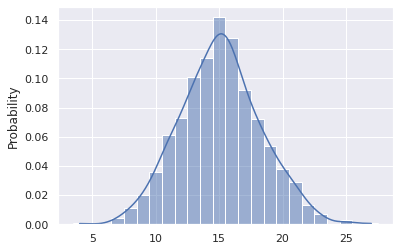

In [31]:
p = 0.3
n = 50
N = 1000

values = gen_bin(n, p, N)
sns.histplot(data = values, kde = True, kde_kws = {"bw_adjust" : 1}, discrete = True, stat = 'probability')
del p, n, N, values

**Item 2**

Function-generator of geometric random variable.

In [60]:
def gen_geom(p, *shape):
    mask = np.ones(shape)
    geom = np.zeros(shape)
    while (len(mask[mask == 1]) != 0):
        attempt = gen_bern(p, *shape)
        mask[attempt == 1] *= 0
        geom = geom + mask
    return geom

Visualization of geometric distribution.

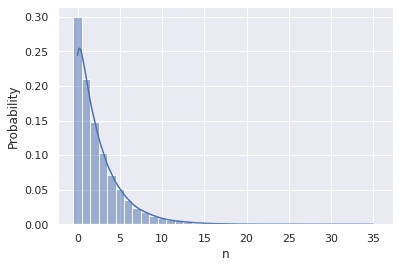

In [61]:
n = 100000
p = 0.3

values = {"n" : gen_geom(p, n)}
sns.histplot(data = pd.DataFrame(values), x = "n", kde = True, kde_kws = {"bw_adjust" : 2}, discrete = True, stat = 'probability')

del n, p, values

Representation of geometric distribution memoryless property:  $\mathbb{P}(\mathbb{X} > m + n \, | \, \mathbb{X} \geq m) = \mathbb{P}(\mathbb{X} > n) $.  
(Previous cell execution required)

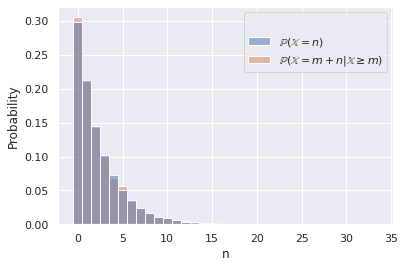

In [62]:
m = 5
n = 100000
p = 0.3

values = {"n" : gen_geom(p, n)}

values[" "] = r'$\mathbb{P}(\mathbb{X} = n)$'

cutted_values = {"n" : [value - m for value in values["n"] if value >= m]}
cutted_values[" "] = r"$\mathbb{P}(\mathbb{X} = m + n | \mathbb{X} \geq m)$"

df_new_values = pd.concat([pd.DataFrame(values), pd.DataFrame(cutted_values)], ignore_index = True)

sns.histplot(data = df_new_values, x = "n", hue = " ", discrete = True, stat = "probability", common_norm = False)

del n, m, p, values, cutted_values, df_new_values

**Item 3**

Trajectory of $ Y(i) = \dfrac{X_1 + X_2 + \dots + X_i}{\sqrt{n}} $, where $ \mathbb{P}(X_i = 1) = \mathbb{P}(X_i = -1) = \dfrac{1}{2}, \quad i = 1, \dots, n $

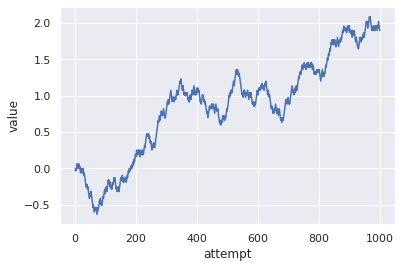

In [67]:
rng = np.random.default_rng()

n = 1000
df = pd.DataFrame(dict(attempt = np.arange(1, n + 1), value = rng.choice(np.array([-1, 1]), n).cumsum() / math.sqrt(n)))
sns.lineplot(x = "attempt", y = "value", data = df)
del rng, n, df

### Task 2

**Item 1**

Python generator for Cantor random variable. Generates list with random variable value and distrubution function at this point.

In [80]:
def gen_cantor(n, eps = 0.0000001):
    result = {"sample": [], "dist function": []}
    N = math.ceil(-math.log(eps,3))
    pow_3_list = [2.0/pow(3,i) for i in range(1,N+1)]
    cant_rand = lambda x: np.dot(pow_3_list, x)
    pow_2_list = [1.0/pow(2,i) for i in range(1,N+1)]
    cant_func = lambda x: np.dot(pow_2_list, x)
    for i in range(n):
        sample = gen_bern(0.5,N)
        result["sample"].append(cant_rand(sample))
        result["dist function"].append(cant_func(sample))
    return result

Kolmogorov distribution function. $ K = 1 + 2 \displaystyle\sum_{k = 1}^{\infty}(-1)^k e^{-2k^2x^2} $

In [79]:
def K(x):
    n = 10000
    sum = 0
    for k in np.arange(1, n + 1):
        sum += (-1)**k * math.e ** (-2 * k**2 * x**2)
    return 1 + 2 * sum

Kolmogorov criteria function. Accepts vector with values of theoretical distribution function in selected points `dist_function` and significance level `alpha`. $D_n $ here is computed using formula: $ D_n(x_1, \dots, x_n) = \displaystyle\max_{1 \le i \le n} \left\{ \dfrac{i}{n} - F(x_{(i)}), F(x_{(i)}) - \dfrac{i - 1}{n} \right\}. $  

In [82]:
def kolmogorov(dist_function, alpha):
    n = len(dist_function)
    sorted_dist_function = sorted(dist_function)
    maxes = np.zeros(n)
    for i in np.arange(1, n + 1):
        maxes[i - 1] = max(i / n - sorted_dist_function[i - 1], sorted_dist_function[i - 1] - (i - 1)/n)
    D_n = max(maxes)

    if 1 - K(math.sqrt(n) * D_n) > alpha:
        return True
    else:
        return False

Distribution function of generated Cantor random variable and verification using Kolmogorov criteria.

accordance: 0.93 %


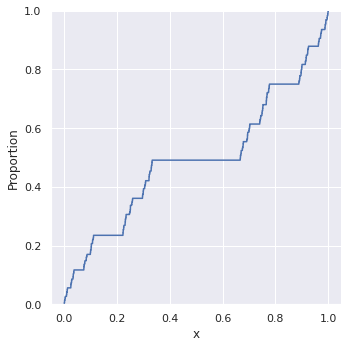

In [88]:
N = 100
n = 1000

selection = np.zeros(n)
dist_function = np.zeros(n)
alpha = 0.05

count = 0
for j in range(N):
    if kolmogorov(gen_cantor(n)["dist function"], alpha):
        count += 1
print("accordance:", count / N, "%")

df = pd.DataFrame({"x" : gen_cantor(n)["sample"]})
sns.displot(data = df, x = "x", kind = "ecdf")

del N, n, selection, dist_function, df, alpha, count

**Item 2**

Computation of empirical distribution function of `selection` in `value` point. $ \hat{F}_n (x) = \dfrac{1}{n} \displaystyle\sum_{i = 1}^n \mathbb{I}(x_i < x) $

In [93]:
def F_hat(selection, value):
    number_less = 0
    for val in selection:
        if val <= value:
            number_less += 1
    return number_less / selection.size

Smirnov criteria function. Accepts two selections `x` and `y`, and significance level `alpha`. $ D_{n,m} = \max \left\{ D_{n,m}^+, D_{n,m}^- \right\}$, где $ D_{n,m}^+ = \displaystyle\sup_{x}(\hat{F}_n(x) - \hat{G}_m(x)) = \displaystyle\max_{1 \le i \le n} \left\{ \frac{i}{n} - \hat{G}_m(x_{(i)}) \right\}, D_{n,m}^- = \displaystyle\sup_{x}(\hat{G}_m(x) - \hat{F}_n(x)) = \displaystyle\max_{1 \le j \le m} \left\{ \frac{j}{m} - \hat{F}_n(y_{(j)}) \right\}. $ Uses $ K(x) $ function.

In [91]:
def smirnov(x,y, alpha):
    n = x.size
    m = y.size
    x.sort()
    y.sort()
    maxes_plus = np.zeros(n)
    maxes_minus = np.zeros(m)
    for i in np.arange(1, n + 1):
        maxes_plus[i - 1] = i / n -  F_hat(y, x[i - 1])
    D_plus = max(maxes_plus)

    for i in np.arange(1, m + 1):
        maxes_minus[i - 1] = i/m - F_hat(x, y[i - 1])
    D_minus = max(maxes_minus)

    D_n_m = max(D_plus, D_minus)
    
    if 1 - K(math.sqrt(n * m / (n + m)) * D_n_m) > alpha:
        return True
    else:
        return False

Cheking uniformity of $ X $ and $ 1 - X $ using Smirnov criteria.

uniformity: 0.8 %


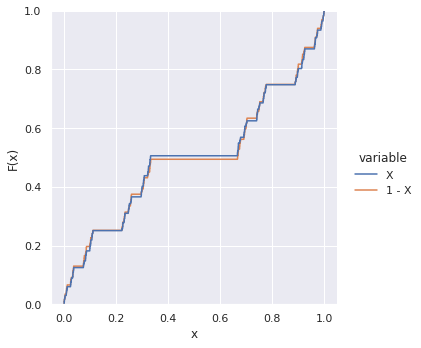

In [95]:
N = 10
n = 1000
x = np.zeros(n)
y = np.zeros(n)
alpha = 0.05

count = 0
for j in range(N):
    x = np.array(gen_cantor(n)["sample"])
    y = 1 - x
    if smirnov(x,y, alpha):
        count += 1

print("uniformity:", count / N, "%")

x_values = {"value" : x}
x_values["variable"] = "X"

y_values = {"value" : y}
y_values["variable"] = "1 - X"

df = pd.concat([pd.DataFrame(x_values), pd.DataFrame(y_values)], ignore_index = True)

graph = sns.displot(data = df, x = "value", hue = "variable", kind = "ecdf")
graph.set_axis_labels("x", "F(x)")

del N, n, x, y, alpha, x_values, y_values, df, graph, count

Cheking uniformity of $ X | X \in [0;\dfrac{1}{3}] $ and $ \dfrac{X}{3} $

uniformity: 1.0 %


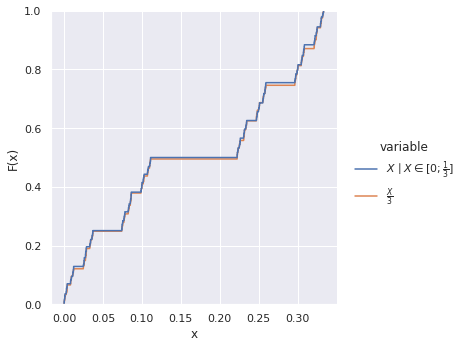

In [97]:
N = 10
n = 1000
x = np.zeros(n)
y = np.zeros(n)
alpha = 0.05

count = 0
for j in range(N):
    x = np.array(gen_cantor(n)["sample"])
    y = x / 3
    x[x >= 2/3] -= 2/3
    if smirnov(x, y, alpha):
        count += 1
print("uniformity:", count / N, "%")

x_values = {"value" : x}
x_values["variable"] = r"$X \mid X \in [0;\frac{1}{3}]$"

y_values = {"value" : y}
y_values["variable"] = r"$\frac{X}{3}$"

df = pd.concat([pd.DataFrame(x_values), pd.DataFrame(y_values)], ignore_index = True)

graph = sns.displot(data = df, x = "value", hue = "variable", kind = "ecdf")
graph.set_axis_labels("x", "F(x)")

del N, n, x, y, alpha, x_values, y_values, df, graph, count

**Item 3**

Illustration of convergence of sample mean and dispersion values to their theoretical analogues.

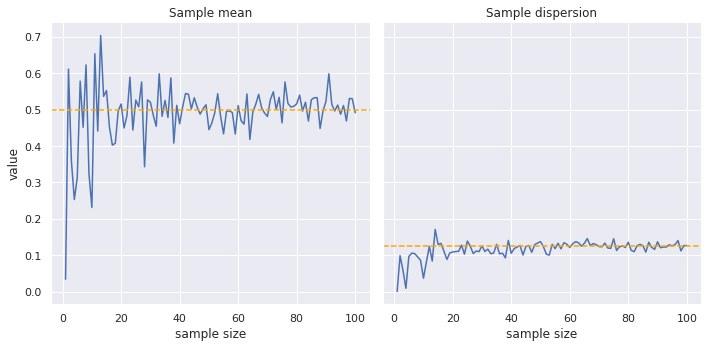

In [100]:
N = 100
E_emp = np.zeros(N)
D_emp = np.zeros(N)
for n in np.arange(1, N + 1):
    selection = np.array(gen_cantor(n)["sample"])
    E_n = sum(selection)/n
    D_n = sum((np.array(selection) - E_n)**2) / n
    E_emp[n-1] = E_n
    D_emp[n-1] = D_n

df_E = pd.DataFrame({"size" : np.arange(1, N + 1), "value" : E_emp, "type" : "mean"})
df_D = pd.DataFrame({"size" : np.arange(1, N + 1), "value" : D_emp, "type" : "dispersion"})
df = pd.concat([df_E, df_D], ignore_index = True)

graph = sns.relplot(x = "size", y = "value", data = df, kind = "line", col = "type")
ax1, ax2 = graph.axes[0]
ax1.axhline(0.5, ls='--', color = 'orange')
ax2.axhline(0.125, ls='--', color = 'orange')
graph.set_axis_labels("sample size", "value")
graph.set_titles("Sample {col_name}")

del N, E_emp, D_emp, D_n, E_n, selection, n, df_E, df_D, df, graph, ax1, ax2

### Task 3

**Item 1**

Inversed distribution function of exponential distribution: $F^{-1}(y) = -\dfrac{1}{\lambda} \ln(1 - y) $.

In [101]:
def inv_exp_func(x, lam):
    return -1/lam * np.log(1 - x)

Python generator of exponential distribution with parameter $\lambda = $`lam`.

In [106]:
def gen_exp(lam, *shape):
    return inv_exp_func(np.random.random(*shape), lam)

Probability density function of exponential distribution: $ p(x) = \lambda e^{-\lambda x} $

In [103]:
def p_exp(lam, x):
    return lam * np.e**(-lam * x)

Visulization of exponential distrubution.

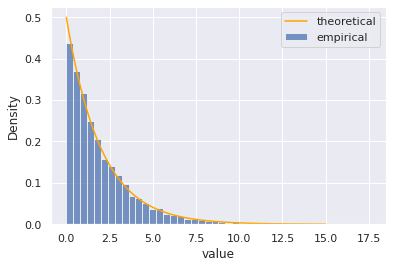

In [107]:
n = 10000
lam = 0.5

values = {"value" : gen_exp(lam, n)}
graph = sns.histplot(data = pd.DataFrame(values), x = "value", label = "empirical", binwidth = 0.4, stat = 'density')
sns.lineplot(x = np.linspace(0, 15, 1000), y = p_exp(lam, np.linspace(0, 15, 1000)), color = "orange", label = "theoretical", ax = graph)

del n, lam, values, graph

Representation of exponential distribution memoryless property: $ \mathbb{P}(X \ge s + t \mid X \ge t) = \mathbb{P}(X \ge s) $.  
(Previous cell execution required)

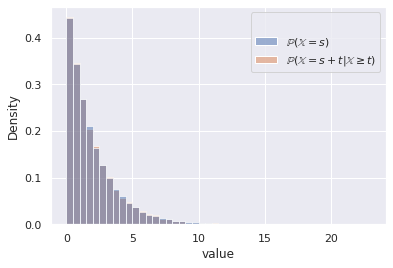

In [110]:
t = 2
n = 100000
lam = 0.5

values = {"value" : gen_exp(lam, n)}

values[" "] = r'$\mathbb{P}(\mathbb{X} = s)$'

cutted_values = {"value" : [value - t for value in values["value"] if value >= t]}
cutted_values[" "] = r"$\mathbb{P}(\mathbb{X} = s + t | \mathbb{X} \geq t)$"

df_new_values = pd.concat([pd.DataFrame(values), pd.DataFrame(cutted_values)], ignore_index = True)

sns.histplot(data = df_new_values, x = "value", hue = " ", binwidth = 0.5, stat = "density", common_norm = False)

del n, t, values, cutted_values, df_new_values

Distribution of $ Y = \min(X_1, X_2, \dots, X_n) $, where $ X_i \sim \mathrm{Exp}(\lambda_i) $.

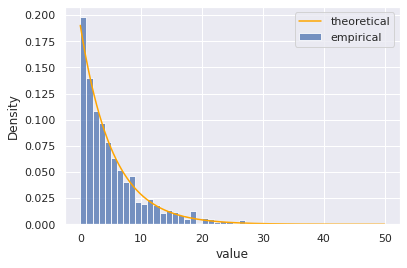

In [121]:
n = 4
N = 1000
lam = [0.1 * np.random.random() for i in range(n)]
Vals = np.zeros((n, N))
for i in range(n):
    Vals[i][:] = gen_exp(lam[i], N)

Y = np.amin(Vals, 0)

values = {"value" : Y}
graph = sns.histplot(data = values, x = "value", binwidth = 1, label = "empirical", stat = 'density')
sns.lineplot(x = np.linspace(0, 50, 1000), y = p_exp(sum(lam), np.linspace(0, 50, 1000)), color = "orange", label = "theoretical", ax = graph)

del i, n, N, lam, Y, graph, values

**Item 2**

Poisson distribution generator. Uses exponential distribution generator.

In [124]:
def gen_pois(l,n):
    out = []
    for i in range(n):
        sm = 0
        num = 0
        while sm <= 1:
            sm += gen_exp(l,1)
            num += 1
        num -= 1
        out.append(num)
    return out

Poisson density function: $ p(k) = \dfrac{\lambda^k e^{-\lambda}}{k!} $.

In [123]:
def p_pois(lam, k):
    return lam**k * np.e**(-lam) / sp.special.factorial(k)

Visualization of Poisson distribution.

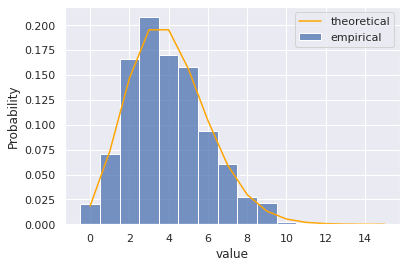

In [127]:
n = 1000
lam = 4

values = {"value" : gen_pois(lam, n)}
graph = sns.histplot(data = values, x = "value", label = "empirical", discrete = True, stat = 'probability')
sns.lineplot(x = np.linspace(0, 15, 16), y = p_pois(lam, np.linspace(0, 15, 16)), color = "orange", label = "theoretical", ax = graph)

del n, lam, values, graph

**Item 3**

Generator of Poisson distribution as limit of binominal distribution.  
$ (n = 10000) $

In [136]:
def gen_binlimit(lam, N):
    n = 10000
    return gen_bin(n, lam/n, N)

Binominal distribution with $ n = 10000 $ and $ p = \dfrac{\lambda}{n} $ compared to theoretical Poisson distribution.

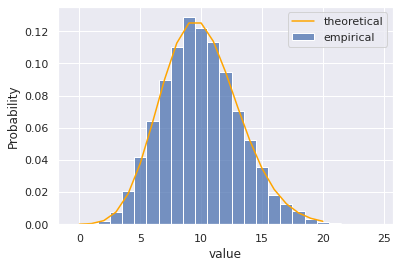

In [157]:
N = 10000
lam = 10
values = {"value" : gen_binlimit(lam, N)}
graph = sns.histplot(data = values, x = "value", label = "empirical", discrete = True, stat = 'probability')
sns.lineplot(x = np.linspace(0, 20, 21), y = p_pois(lam, np.linspace(0, 20, 21)), color = "orange", label = "theoretical", ax = graph)

del N, lam, values, graph

$ \chi_k^2 $ comulative distribution function of chi-squared distribution. $ F_{\chi_k^2}(x) = \dfrac{\gamma(k/2, x/2)}{\Gamma(k/2)} $

In [141]:
def chi_dist(k, x):
    return sp.special.gammainc(k/2, x/2) / sp.special.gamma(k/x)

Pirson chi-squared criteria. Accepts sample array `values`, density values in sample points `density_func` and significance level `alpha`. Statistic: $ X_n^2 = n \displaystyle\sum_{j = 1}^N \dfrac{1}{p_j^0}(\hat{p}_j - p_j^0)^2 = \displaystyle\sum_{j = 1}^N \dfrac{(\nu_j - np_j^0)^2}{np_j^0}. $ Prints $ 1 - \mathbb{P}(X_n^2 < X_n^{*2}).$

In [140]:

def pirson(values, density_func, alpha):
    n = values.size
    unique, counts = np.unique(values, return_counts = True)
    N = unique.size
    unique_density_func = np.array([density_func[list(values).index(value)] for value in unique])
    X_n = sum((counts - n * unique_density_func)**2 / (n * unique_density_func))
    if 1 - chi_dist(N - 1, X_n) > alpha:
        return True
    else:
        return False

Creating and verification of sample. 

In [180]:
N = 100
lam = 10
alpha = 0.05

count = 0
for j in range(N):
    values = np.array(gen_binlimit(lam, N))
    if pirson(values, p_pois(lam, values), alpha):
        count += 1
print("accordance:", count / N, "%")

del N, lam, alpha, j, count, values

accordance: 0.94 %


**Item 4**

Standart normally-distributed variable generator. $ X = \sqrt{-2 \ln\eta_1} \cos(2 \pi \eta_2) $, where $ \eta_1 $ and $ \eta_2 $ - pair of uniformly distributed variables.

In [195]:
def stand_norm_gen_cos(n):
    return np.sqrt(-2 * np.log(np.random.random(n))) * np.cos(2 * np.pi * np.random.random(n))

Standart normally-distributed variable generator. $ X = \sqrt{-2 \ln\eta_1} \sin(2 \pi \eta_2) $, where $ \eta_1 $ and $ \eta_2 $ - pair of uniformly distributed variables.

In [193]:
def stand_norm_gen_sin(n):
    return np.sqrt(-2 * np.log(np.random.random(n))) * np.sin(2 * np.pi * np.random.random(n))

Density function of normal distribution with parameters $ \mu $(`mu`) and $ \sigma $ (`sigma`)

In [184]:
def p_norm(mu, sigma, x):
    return 1/(sigma * np.sqrt(2 * np.pi)) * np.exp(-(x - mu)**2 / (2 * sigma**2))

Density of standart normal distribution generated using pair of uniformly distributed values compared to theoretical density.

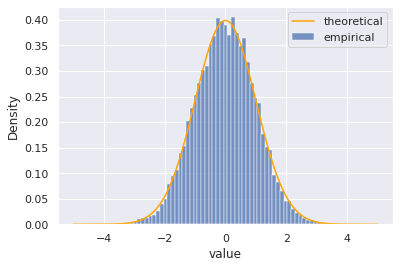

In [196]:
N = 10000
values = {"value" : stand_norm_gen_cos(N)}
graph = sns.histplot(data = values, x = "value", label = "empirical", stat = 'density')
sns.lineplot(x = np.linspace(-5, 5, 1000), y = p_norm(0, 1, np.linspace(-5, 5, 1000)), color = "orange", label = "theoretical", ax = graph)

del N, values, graph

Computing $ S^2 $ for a given sample.

In [197]:
def get_S(sample):
    n = sample.size
    mean = sum(sample)/n
    S = sum((sample - mean)**2)/(n - 1)
    return S

Fisher criteria. Accepts two samples `sample_1` and `sample_2` to find out if their variances are equal and significance level `alpha`. Statistic: $S_1^2 / S_2^2 \sim F_{k_1, k_2}$, where $ S_1^2 = \dfrac{1}{n - 1} \sum_{i = 1}^{n}(X_i - \overline{X})^2, \quad S_2^2 = \dfrac{1}{m - 1} \sum_{i = 1}^{m}(Y_i - \overline{Y})^2 $

In [198]:
def fisher(sample_1, sample_2, alpha):
    S_1 = get_S(sample_1)
    S_2 = get_S(sample_2)
    n = sample_1.size
    m = sample_2.size
    if (sp.stats.f.cdf(S_1/S_2, n-1, m-1) < alpha/2) | (sp.stats.f.cdf(S_1/S_2, n-1, m-1) > 1 - alpha/2):
        return False
    else:
        return True

Creation of samples and verification of variances equalness.

In [201]:
N = 100
n = 1000
alpha = 0.1
count = 0
for i in range(N):
    sample_1 = np.array(stand_norm_gen_sin(n))
    sample_2 = np.array(stand_norm_gen_cos(n))
    if fisher(sample_1, sample_2, alpha):
        count += 1
print("variances equalness:", count / N, "%")

del N, n, alpha, count, i, sample_1, sample_2

variances equalness: 0.96 %


Student criteria. Accepts two samples `sample_1` and `sample_2` to find out if their mean values are equal and significance level `alpha`. Statistic: $ T = \left( \overline{X} - \overline{Y} \right) \left/ \left( S_{tot} \sqrt{\dfrac{1}{n} + \dfrac{1}{m}} \right) \right. = \left. \sqrt{\dfrac{nm}{n + m}} \left(\overline{X} - \overline{Y} \right) \right/ S_{tot} \sim t_{n + m - 2}, $ where $ S_{tot} = \left[(n - 1) S_1^2 + (m - 1) S_2^2 \right] / (n + m -2) $

In [202]:
def student(sample_1, sample_2, alpha):
    S_1 = get_S(sample_1)
    S_2 = get_S(sample_2)
    n = sample_1.size
    m = sample_2.size
    mean_1 = sum(sample_1)/n
    mean_2 = sum(sample_2)/m
    S_tot = ((n - 1) * S_1 + (m - 1) * S_2)/(n + m - 2)
    T = np.sqrt(n * m/(n + m)) * (mean_1 - mean_2) / S_tot
    if (sp.stats.t.cdf(T, n + m - 2) < alpha/2) | (sp.stats.t.cdf(T, n + m - 2) > 1 - alpha/2):
        return False
    else: 
        return True

Creation of samples and verification of mean values equalness.

In [208]:
N = 100
n = 1000
alpha = 0.1
count = 0
for i in range(N):
    sample_1 = np.array(stand_norm_gen_sin(n))
    sample_2 = np.array(stand_norm_gen_cos(n))
    if student(sample_1, sample_2, alpha):
        count += 1
print("mean values equalness:", count / N, "%")

del N, n, alpha, count, i, sample_1, sample_2

mean values equalness: 0.86 %


### Task 4

**Item 1**

Cauchy distribution generator with parameters `a` and `b`.

In [209]:
def cauchy_gen(a, b, n):
    return a + b * np.tan(np.pi * (np.random.random(n) - 1/2))

Theoretical Cauchy density function.

In [210]:
def cdf_cauchy(a, b, x):
    return np.arctan((x - a)/b)/np.pi + 1/2 

Visualisation of generated Cauchy sample compared to theretical Cauchy distribution.

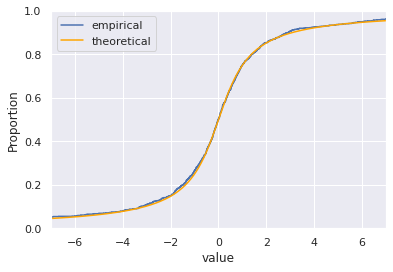

In [211]:
N = 1000
values = {"value" : cauchy_gen(0,1,N)}
graph = sns.ecdfplot(data = values, x = "value", label = "empirical")
sns.lineplot(x = np.linspace(-7, 7, 1000), y = cdf_cauchy(0, 1, np.linspace(-7, 7, 1000)), color = "orange", label = "theoretical", ax = graph)
graph.set_xlim([-7, 7])

del N, values, graph

**Item 2**

Cauchy density function.

In [212]:
def p_cauchy(a, b, x):
    return b / (np.pi * ((x - a)**2 + b**2))

Fon-Neyman standart normal distrubution generator.

In [216]:
def gen_normal_neu(n):
    bas, X = math.ceil(n/10), np.array([])
    while np.size(X) < n:
        x = cauchy_gen(0, 1, bas)
        nu = np.random.rand(bas) < np.sqrt(np.e)/2 * (np.e ** (-x**2 / 2)) * (x**2 + 1)
        X = np.concatenate((X,x[nu]))
    X = X[0:n]   
    return X

Creation of sample and verification using `sp.stats.probplot()`.

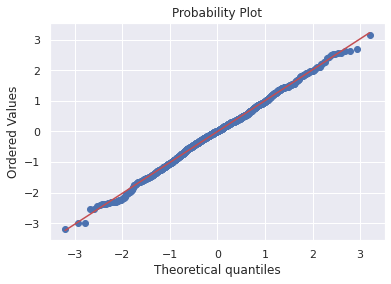

In [217]:
N = 1000
values = np.array(gen_normal_neu(N))
sp.stats.probplot(values, plot = sns.mpl.pyplot)

del N, values

**Item 3**

Speed comparison of two standart normal distribution generators.

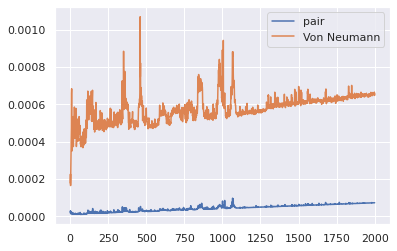

In [237]:
N = 2000
attempts = 10
times_pair = np.zeros(N)
times_fon_neyman = np.zeros(N)
for j in np.arange(1, N + 1):
    tic = time.perf_counter()
    for i in range(attempts):
        sample = stand_norm_gen_cos(j)
    toc = time.perf_counter()
    times_pair[j - 1] = (toc - tic) / attempts

    tic = time.perf_counter()
    for i in range(attempts):
        sample = gen_normal_neu(j)
    toc = time.perf_counter()
    times_fon_neyman[j - 1] = (toc - tic) / attempts

graph = sns.lineplot(x = np.arange(1, N + 1), y = times_pair, label = "pair")
sns.lineplot(x = np.arange(1, N + 1), y = times_fon_neyman, label = "Von Neumann", ax = graph)

del N, times_pair, times_fon_neyman

### Task 5

**Item 1**

Law of large numbers.

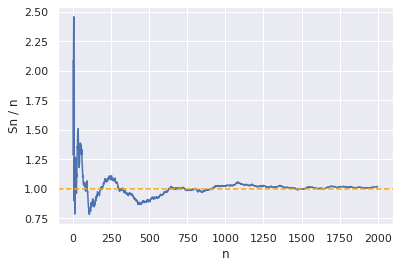

In [236]:
N = 2000
mu = 1
sigma = 2
sample = np.array(stand_norm_gen_cos(N)) * sigma + mu
mean = sample.cumsum() / np.arange(1, N + 1)
graph = sns.lineplot(x = np.arange(1, N + 1), y = mean)
graph.axhline(mu, ls='--', color = 'orange')
graph.set_xlabel("n")
graph.set_ylabel("Sn / n")

del N, mu, sigma, sample, mean, graph

Central limit theorem.

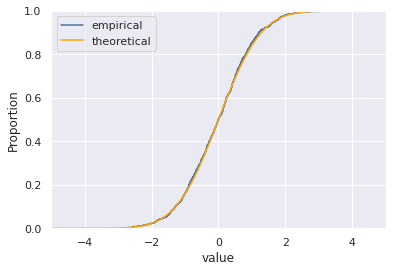

In [235]:
N = 1000
n = 1000
mu = 1
sigma = 2
X = np.zeros(N)
for i in range(N):
    sample = np.array(stand_norm_gen_cos(n))
    sample = sample * sigma + mu
    X[i] = (sum(sample) - mu * n) / (sigma * np.sqrt(n))
values = {"value" : X}
graph = sns.ecdfplot(data = values, x = "value", label = "empirical")
sns.lineplot(x = np.linspace(-5, 5, 1000), y = sp.stats.norm.cdf(np.linspace(-5, 5, 1000)), color = "orange", label = "theoretical", ax = graph)
graph.set_xlim([-5, 5])

del N, n, mu, sigma, X, sample, values, graph, i

**Item 2**

Confidence interval for math expectation.

/tmp/ipykernel_2599/2087429299.py:4: RuntimeWarning: invalid value encountered in double_scalars
  S = sum((sample - mean)**2)/(n - 1)


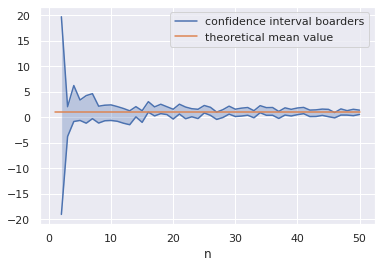

In [241]:
N = 50
mu = 1
sigma = 2
alpha = 0.05
lower_boarder = np.zeros(N)
upper_boarder = np.zeros(N)
Mean = np.zeros(N)
for n in range(N):
    sample = np.array(stand_norm_gen_cos(n+1))
    sample = sample * sigma + mu
    mean = sum(sample) / (n + 1)
    S = np.sqrt(get_S(sample))
    lower_boarder[n] = mean - sp.stats.t.ppf(1 - alpha/2, n) * S / np.sqrt(n)
    upper_boarder[n] = mean + sp.stats.t.ppf(1 - alpha/2, n) * S / np.sqrt(n)
    Mean[n] = mean
graph = sns.lineplot(x = np.arange(1, N + 1), y = upper_boarder, color = sns.color_palette()[0], label = "confidence interval boarders")
sns.lineplot(x = np.arange(1, N + 1), y = lower_boarder)
sns.lineplot(x = np.arange(1, N + 1), y = mu * np.ones(N), label = "theoretical mean value")
graph.fill_between(np.arange(1, N + 1), upper_boarder, lower_boarder, alpha = 0.3)
graph.set_xlabel("n")

del N, mu, sigma, alpha, lower_boarder, upper_boarder, Mean, n, S, graph, mean, sample

Confidence interval for variance.

/tmp/ipykernel_2599/2087429299.py:4: RuntimeWarning: invalid value encountered in double_scalars
  S = sum((sample - mean)**2)/(n - 1)


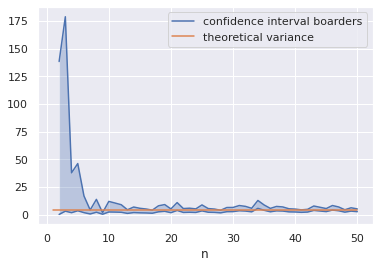

In [243]:
N = 50
mu = 1
sigma = 2
alpha = 0.1
lower_boarder = np.zeros(N)
upper_boarder = np.zeros(N)
Mean = np.zeros(N)
for n in range(N):
    sample = np.array(stand_norm_gen_cos(n+1))
    sample = sample * sigma + mu
    mean = sum(sample) / (n + 1)
    S = get_S(sample)
    lower_boarder[n] = n * S / sp.stats.chi2.ppf(alpha/2, n)
    upper_boarder[n] = n * S / sp.stats.chi2.ppf(1 - alpha/2, n)
    Mean[n] = mean
graph = sns.lineplot(x = np.arange(1, N + 1), y = upper_boarder, color = sns.color_palette()[0], label = "confidence interval boarders")
sns.lineplot(x = np.arange(1, N + 1), y = lower_boarder)
sns.lineplot(x = np.arange(1, N + 1), y = sigma**2 * np.ones(N), label = "theoretical variance")
graph.fill_between(np.arange(1, N + 1), upper_boarder, lower_boarder, alpha = 0.3)
graph.set_xlabel("n")

del N, mu, sigma, alpha, lower_boarder, upper_boarder, Mean, n, S, graph, mean, sample

**Item 3**

Law of large numbers for Cauchy distribution.

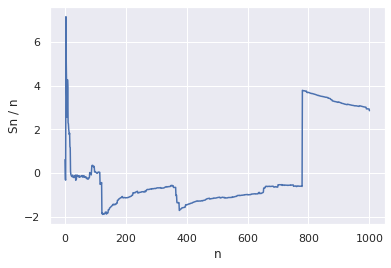

In [245]:
N = 1000
sample = np.array(cauchy_gen(0, 1, N))
mean = sample.cumsum() / np.arange(1, N + 1)
graph = sns.lineplot(x = np.arange(1, N + 1), y = mean)
graph.set_xlabel("n")
graph.set_ylabel("Sn / n")

del N, sample, mean, graph

Cauchy CDF and sample mean CDF. Illustration of $ \overline{X} \sim C(a,b) $

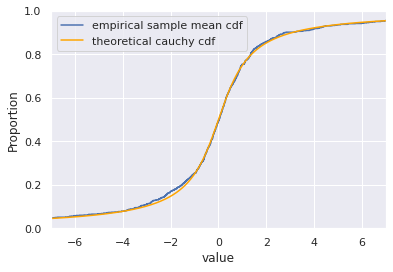

In [247]:
N = 1000
n = 1000
a = 0
b = 1
X = np.zeros(N)
for i in range(N):
    sample = np.array(cauchy_gen(a, b, n))
    X[i] = sum(sample)/n
values = {"value" : X}
graph = sns.ecdfplot(data = values, x = "value", label = "empirical sample mean cdf")
sns.lineplot(x = np.linspace(-7, 7, 1000), y = cdf_cauchy(a, b, np.linspace(-7, 7, 1000)), color = "orange", label = "theoretical cauchy cdf", ax = graph)
graph.set_xlim([-7, 7])

del N, n, a, b, X, sample, values, graph, i

### Task 6

**Item 1**

In [248]:
def f(x):
    x_2 = x[0]**2 * x[1]**2 * x[2]**2 * x[3]**2 * x[4]**2 * x[5]**2 * x[6]**2 * x[7]**2 * x[8]**2 * x[9]**2
    return np.sqrt(np.pi**10) * np.exp(-1/(2**7 * x_2)) / x_2

Monte-Carlo method for 	$ \int\limits_{-\infty}^{\infty} \int\limits_{-\infty}^\infty \cdots \int\limits_{-\infty}^\infty \frac{e^{-\left(x_1^2 + \ldots + x_{10}^2 + \frac{1}{ 2^7\cdot x_1^2 \cdot \ldots \cdot x_{10}^2}\right)}}{x_1^2 \cdot \ldots \cdot x_{10}^2}dx_1\ldots dx_{10} $ integral.

In [249]:
x = sp.stats.norm.rvs(0, 1/2, 10)
tic = time.perf_counter()
n = 10**4
alpha = 0.05
x_p = sp.stats.norm.ppf(1 - alpha/2)
sample = np.array([f(sp.stats.norm.rvs(0, 1/np.sqrt(2), 10)) for i in range(n)])
sigma = np.sqrt(1/n * sum(sample**2) - (1/n * sum(sample))**2)
eps = sigma * x_p / np.sqrt(n)
I = sum(sample)/n
toc = time.perf_counter()
t = toc - tic
print("I:", I, " eps:", eps, " time:", t)

del tic, toc, n, alpha, x_p, sample, sigma, eps, I, t

I: 130.47191762067183  eps: 22.649165979856924  time: 0.8545044620004774


In [250]:
def quadr_f(x):
    sum_1 = 0
    prod_1 = 1
    prod_2 = 1
    for i in range(10):
        sum_1 += np.tan(np.pi * x[i] / 2)**2
        prod_1 *= np.tan(np.pi * x[i] / 2)**2
        prod_2 *= np.sin(np.pi * x[i] / 2)**2
    return np.exp(-(sum_1 + 1 / (2**7 * prod_1))) / prod_2

The quadrature method.

In [2]:
def count_int_RS(n):
        mesh_1d = np.linspace(0, 1, n+2)[1:-1]
        mesh_10d = np.array(np.meshgrid( mesh_1d, mesh_1d, mesh_1d, mesh_1d, mesh_1d,\
                                 mesh_1d, mesh_1d, mesh_1d, mesh_1d, mesh_1d))

        pi2  = (np.pi/2)*mesh_10d

        sin2 = np.sin(pi2)**2
        cos2 = np.cos(pi2)**2
        tg2 = sin2/cos2

        In = (np.pi/n)**10 * np.sum( np.e**( - (np.sum(tg2,axis=0) + 1/(2**7 * np.prod(tg2,axis=0)))) / np.prod(sin2, axis=0))
        return In

tic = time.perf_counter()
I = count_int_RS(5)
toc = time.perf_counter()
t = toc - tic
print("I:", I, " time:", t)

I: 794.7241008539679  time: 2.8359009560008417
